In [1]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# installing dependencies
! pip install transformers datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00


In [3]:
# importing required libraries
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:
# reading the training dataset
train_df = pd.read_csv('/content/drive/MyDrive/NLP/data/BackTranslationAugData.csv')
train_df = train_df[train_df.text.notnull()]
train_df['text'] = train_df['text'].str[:100]
train_df.head()

,text,label
0,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...,1
1,मेट्रो की इस लाइन के चलने से साउथ दिल्ली से नो...,1
2,इस मेट्रो रेल लाइन से दक्षिण दिल्ली से नोएडा क...,1
3,इस रूट पर मेट्रो चलने से साउथ दिल्ली से नोएडा ...,1
4,इस मेट्रो लाइन के शुरू होने से साउथ दिल्ली से ...,1


In [29]:
# reading the testing dataset
test_df = pd.read_csv('/content/drive/MyDrive/NLP/data/clean-hindi-test.csv')
test_df = test_df[test_df.text.notnull()]
test_df['text'] = test_df['text'].str[:100]
test_df.head()

,label,text
0,1,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1,1,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2,1,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3,2,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4,1,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...


In [30]:

# splitting the data into training and validation set
num_of_rows = int(len(train_df) * 0.8)
values = train_df.values
np.random.shuffle(values)
train_df = values[:num_of_rows] 
validation_df = values[num_of_rows:]
train_df = pd.DataFrame(train_df, columns = ['text','label'])
validation_df = pd.DataFrame(validation_df, columns = ['text','label'])
# train_df.rename(columns = {'headline': 'text'}, inplace = True)
# validation_df.rename(columns = {'headline': 'text'}, inplace = True)
# test_df.rename(columns = {'headline': 'text'}, inplace = True)
print(train_df.shape, validation_df.shape, test_df.shape)

(9392, 2) (2349, 2) (640, 2)


In [31]:
train_df.head()

,text,label
0,इसका मतलब हर संभव कोण से एक जर्जर स्थिति है।,2
1,कश्मीरी मूल के गिलानी को दिल्ली पुलिस की स्पेश...,1
2,दोनों पक्षों के अधिकारियों के मुताबिक रूस के क...,2
3,वे इसे कैदी नंबर 210 के नाम से दर्शकों के सामन...,0
4,सऊदी अरब उनके दौरे का दूसरा पड़ाव है मिस्र के ...,2


In [32]:
# loading dataset using Dataset Loader
train_df_hg = Dataset(pa.Table.from_pandas(train_df))
validation_df_hg = Dataset(pa.Table.from_pandas(validation_df))
test_df_hg = Dataset(pa.Table.from_pandas(test_df))

In [33]:
# tokenizing datasets using  mBERT
checkpoint = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'],truncation = True)

train_df_tokenised = train_df_hg.map(tokenize_function, batched = True)
validation_df_tokenised = validation_df_hg.map(tokenize_function, batched = True)
test_df_tokenised = test_df_hg.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'tf')

Map:   0%|          | 0/9392 [00:00<?, ? examples/s]

Map:   0%|          | 0/2349 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

In [34]:
# converting datasets to tensorflow datasets
tf_train_dataset = train_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_validation_dataset = validation_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_test_dataset = test_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [35]:
# loading the model for classification
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, from_pt = True, num_labels = 3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# defining hyper parameters
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 0.0, decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [37]:
# compiling the model
model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [38]:
# adding early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 3 )

In [39]:
# training the model
history = model.fit(tf_train_dataset, callbacks = early_stopping_callback, validation_data = tf_validation_dataset, epochs = 100, verbose = 2, batch_size = 128)

Epoch 1/100
1174/1174 - 224s - loss: 0.9043 - accuracy: 0.5563 - val_loss: 0.9407 - val_accuracy: 0.5424 - 224s/epoch - 191ms/step
Epoch 2/100
1174/1174 - 155s - loss: 0.9537 - accuracy: 0.5402 - val_loss: 0.9409 - val_accuracy: 0.5424 - 155s/epoch - 132ms/step
Epoch 3/100
1174/1174 - 155s - loss: 0.9498 - accuracy: 0.5429 - val_loss: 0.9403 - val_accuracy: 0.5424 - 155s/epoch - 132ms/step
Epoch 4/100
1174/1174 - 163s - loss: 0.9498 - accuracy: 0.5423 - val_loss: 0.9408 - val_accuracy: 0.5424 - 163s/epoch - 139ms/step
Epoch 5/100
1174/1174 - 155s - loss: 0.9499 - accuracy: 0.5423 - val_loss: 0.9417 - val_accuracy: 0.5424 - 155s/epoch - 132ms/step
Epoch 6/100
1174/1174 - 156s - loss: 0.9483 - accuracy: 0.5427 - val_loss: 0.9403 - val_accuracy: 0.5424 - 156s/epoch - 133ms/step
Epoch 7/100
1174/1174 - 154s - loss: 0.9487 - accuracy: 0.5425 - val_loss: 0.9424 - val_accuracy: 0.5424 - 154s/epoch - 132ms/step
Epoch 8/100
1174/1174 - 155s - loss: 0.9474 - accuracy: 0.5425 - val_loss: 0.9403 -

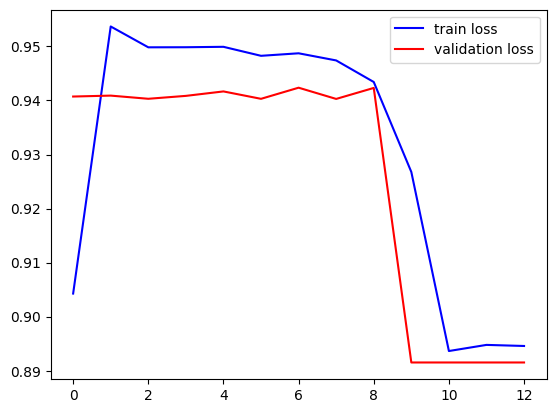

In [40]:
# plotting the loss curve
plt.plot(history.history['loss'], c = 'b', label = 'train loss')
plt.plot(history.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

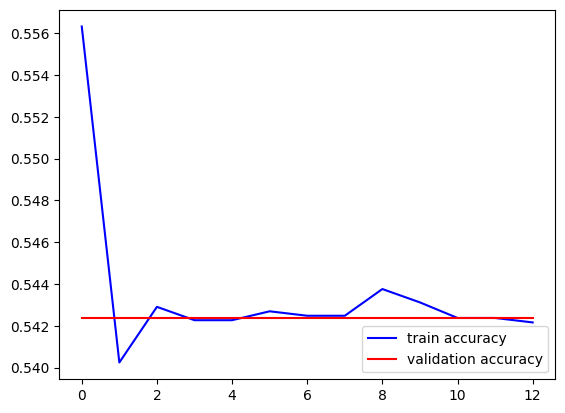

In [41]:
# plotting the accuracy curve
plt.plot(history.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [42]:
# using the trained model to predict the test labels
preds = model.predict(tf_test_dataset)['logits']
class_preds = np.argmax(preds, axis = 1)
print(preds.shape, class_preds.shape)

80/80 [==============================] - 8s 45ms/step
(640, 3) (640,)


In [43]:
y_test = test_df.label.values
y_pred = class_preds

In [44]:
# evaluating the predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 55.78%


In [45]:
# printing the classification results
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.56      1.00      0.72       357
           2       0.00      0.00      0.00       212

    accuracy                           0.56       640
   macro avg       0.19      0.33      0.24       640
weighted avg       0.31      0.56      0.40       640



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# printing the confusion matrix for the classification
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  0  71   0]
 [  0 357   0]
 [  0 212   0]]
